In [2]:
# import dependencies
import h5py
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation

In [11]:
# set constants
FOLDER_PATH = ""
# FOLDER_PATH = "../../HS-AFM-Dataset/dataset/mini_0uM_10ns/1/"

START_TIME = 20000
END_TIME = 80000
STEP = 10
NORMALIZATION_FACTOR = 0.1 # 0.01 for 100 ns/px

MIN_Z = 20
MAX_Z = 60
MIN_XY = 20
MAX_XY = 60

FLOATER_RADIUS = 3

In [12]:
def get_counts_maps(path):
    fg_counts_map      = np.zeros(shape=(MAX_XY - MIN_XY, MAX_XY - MIN_XY, MAX_Z - MIN_Z))
    floater_counts_map = np.zeros(shape=(MAX_XY - MIN_XY, MAX_XY - MIN_XY, MAX_Z - MIN_Z))
    
    with gzip.open(path, "rb") as f:
        f = h5py.File(f, "r")
        
        # Process fg density
        fg_data = f["fg_xyz_hist"]
        n_counts_maps = int(len(fg_data.keys()) / 2)
        for i, key in enumerate(fg_data.keys()):
            fg_counts_map[:, :, :] += np.array(fg_data[key][MIN_XY:MAX_XY,MIN_XY:MAX_XY,MIN_Z:MAX_Z])

        # Process floater density
        floater_data = f["floater_xyz_hist"]
        n_counts_maps = len(floater_data.keys())
        for i, key in enumerate(floater_data.keys()):
            floater_counts_map[:, :, :] = np.array(floater_data[key][MIN_XY:MAX_XY,MIN_XY:MAX_XY,MIN_Z:MAX_Z])
            
    return fg_counts_map, floater_counts_map

def enlarge_floater_counts_map(floater_counts_map, radius):
    # Get the dimensions of the input array
    depth, height, width = floater_counts_map.shape
    
    # Create a larger array to accommodate the enlarged signals
    enlarged = np.zeros((depth + 2*radius, height + 2*radius, width + 2*radius))
    
    # Find the coordinates of non-zero entries
    non_zero = np.nonzero(floater_counts_map)
    
    # Create a meshgrid for the ball
    z, y, x = np.ogrid[-radius:radius+1, -radius:radius+1, -radius:radius+1]
    ball = x*x + y*y + z*z <= radius*radius
    
    # Enlarge each non-zero entry
    for z, y, x in zip(*non_zero):
        enlarged[z:z+2*radius+1, y:y+2*radius+1, x:x+2*radius+1] += ball * floater_counts_map[z, y, x]
    
    # Crop the enlarged array to match the original dimensions
    enlarged = enlarged[radius:-radius, radius:-radius, radius:-radius]
    
    return enlarged

def get_density_maps(f_path, t):
    fg_counts_map, floater_counts_map = get_counts_maps(f_path)
    floater_counts_map  = enlarge_floater_counts_map(floater_counts_map, FLOATER_RADIUS)
    fg_density_map      = fg_counts_map      * NORMALIZATION_FACTOR
    floater_density_map = floater_counts_map * NORMALIZATION_FACTOR
    density_map         = (fg_density_map + floater_density_map) / 2
    return fg_density_map, floater_density_map, density_map

def get_center_of_mass(density_map):
    normalizer = np.sum(density_map)
    grids      = np.ogrid[[slice(0, i) for i in density_map.shape]]
    results    = [np.sum(density_map * grids[dir].astype(float)) / normalizer
                  for dir in range(density_map.ndim)]
    if np.isscalar(results[0]):
        # return tuple(results)
        return np.array(results)
    # return [tuple(v) for v in np.array(results).T]
    return np.array(results)

def get_centers_of_mass_npc(f_path, t):
    fg_density_map, floater_density_map, density_map = get_density_maps(f_path, t)
    return (get_center_of_mass(fg_density_map), get_center_of_mass(floater_density_map), get_center_of_mass(density_map))
    
    

In [28]:
def get_center_of_mass_dataset(path_prefix):
    n_points = int((END_TIME - START_TIME) / STEP)
    fg_coms  = np.zeros(shape=(3, n_points))
    ntr_coms = np.zeros(shape=(3, n_points))
    avg_coms = np.zeros(shape=(3, n_points))
    for i, t in enumerate(range(START_TIME, END_TIME, STEP)):
        if i%50 == 0:
            print(t)
        fg_com, ntr_com, avg_com = get_centers_of_mass_npc(f"{path_prefix}{t}.hdf5.gz", t)
        fg_coms[:, i]  = fg_com
        ntr_coms[:, i] = ntr_com
        avg_coms[:, i] = avg_com
    results = {"fg": fg_coms, "ntr": ntr_coms, "avg": avg_coms}
    return results

def plot_centers_of_mass(mass_dataset, axis=0, moving_average_n=1000):
    fg_plot = np.convolve(mass_dataset["fg"][axis, :] - 19.5, np.ones(moving_average_n)/moving_average_n, mode='valid')
    ntr_plot = np.convolve(mass_dataset["ntr"][axis, :] - 19.5, np.ones(moving_average_n)/moving_average_n, mode='valid')
    x_range = range(START_TIME, END_TIME - STEP * (moving_average_n - 1) , STEP)
    
    axis_letter_dict = {0: "x", 1 : "y", 2 : "z"}
    plt.plot(x_range, fg_plot , label = "FG")
    plt.plot(x_range, ntr_plot, label = "NTR")
    # plt.plot(range(START_TIME, END_TIME, STEP), mass_dataset["avg"][0, :], label = "AVG")
    plt.title(f'Center of Mass {axis_letter_dict[axis]}-axis over time')
    plt.xlabel("time (ns)")
    plt.ylabel(f"Center of Mass {axis_letter_dict[axis]}-axis (nm)")
    plt.legend()
    plt.show()

In [14]:
data = get_center_of_mass_dataset("../../HS-AFM-Dataset/dataset/interaction_site_experiment/6_sites/")
with open("../6_sites_com_data.pickle", "wb") as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500


In [15]:
with open("../6_sites_com_data.pickle", "rb") as f:
    data = pickle.load(f)

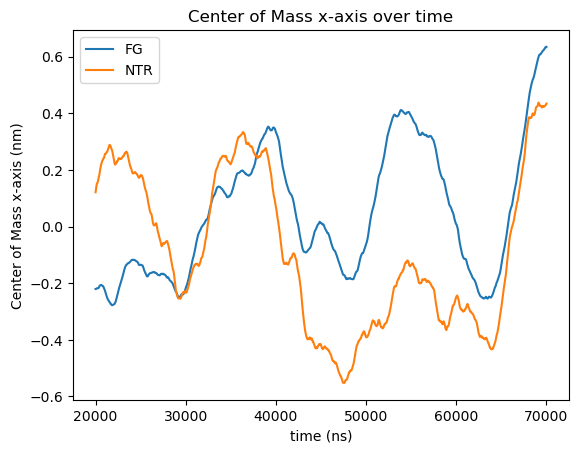

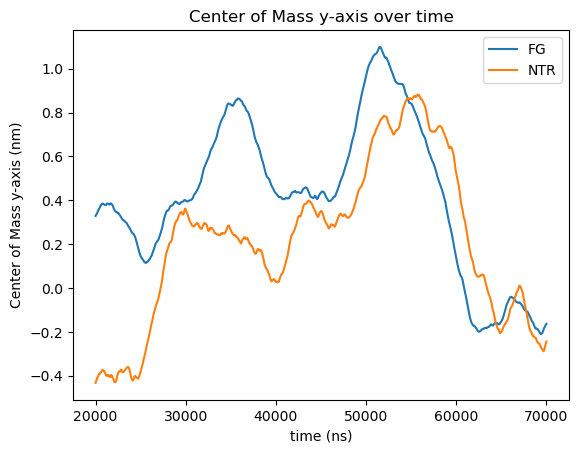

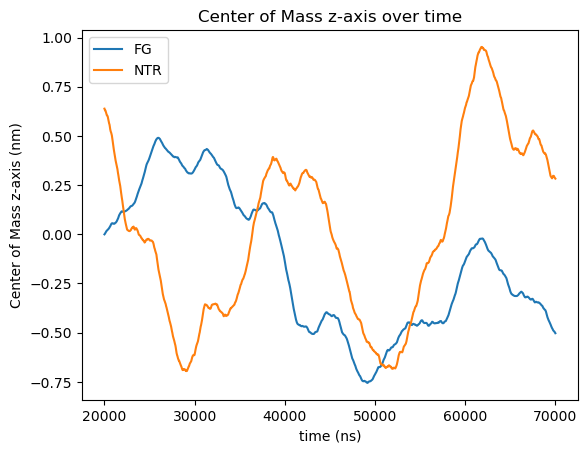

In [29]:
plot_centers_of_mass(data)
plot_centers_of_mass(data, 1)
plot_centers_of_mass(data, 2)

In [ ]:
plot_centers_of_mass("../../HS-AFM-Dataset/dataset/interaction_site_experiment/7_sites/")

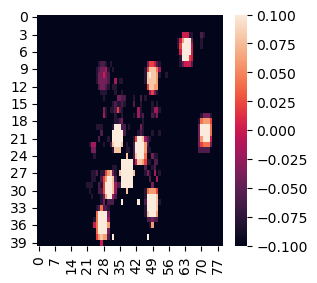

In [30]:
dimension = (MAX_XY - MIN_XY, MAX_Z - MIN_Z)

fig, ax = plt.subplots(figsize=(3, 3))  # Reduce the figure size

def init():
    data = np.zeros(dimension)
    ax.clear()
    sns.heatmap(data, ax=ax)
    
def animate(i):
    t = START_TIME + (i * STEP)
    data = get_density_map(t)
    ax.clear()
    sns.heatmap(data, ax=ax, cbar=False)
    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=10, repeat=False)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=3600)
anim.save('animated_heatmap.gif', writer=writer)
plt.show()
